In [1]:
from app.rl.tictactoe.t3_test import T3Model, convert_inputs
from gym_tic_tac_toe.envs.tic_tac_toe_env import TicTacToeEnv, Pix
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = T3Model(8).double().to(device)

99, 199, 299, 399, 499, 599, 699, 799, 899, 999, 

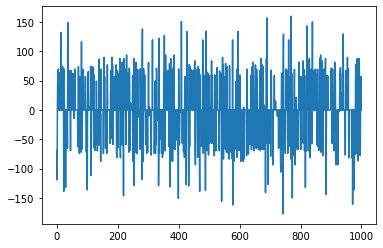

In [17]:
def get_credits(t, gamma):
    credits = []
    prev_credit = 1
    for i in range(t):
        credits.append(prev_credit)
        prev_credit *= gamma
    return torch.tensor(list(reversed(credits))).double().to(device)


def get_returns(stats, gamma):
    total_t = len(stats)
    returns = []
    prev_return = 0
    for t in range(total_t):
        prev_return = stats[total_t - t -1][1] + (gamma * prev_return)
        returns.append(prev_return)
    return torch.tensor(list(reversed(returns))).double().to(device)


def get_loss(stats):
    loss = 0
    for i_env in range(len(stats)):
        returns = get_returns(stats[i_env], gamma=0.98)

        probs = torch.stack([stat[0] for stat in stats[i_env]])
        probs = torch.log(probs)

        credits = get_credits(len(stats[i_env]), gamma=0.95)

        loss += torch.sum(probs * credits * returns) / len(stats[i_env])
    return -1 * loss / len(stats)


def train():
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=1e-1)
    batch_size = 2
    envs = [TicTacToeEnv() for _ in range(batch_size)]
    losses = []

    for epoch in range(1000):

        stats = [[] for _ in range(batch_size)]
        is_dones = [False for _ in range(batch_size)]
        _ = [env.reset() for env in envs]

        # Monte Carlo loop
        for i_step in range(15):

            legal_actions = [env.get_legal_actions() for env in envs]

            if i_step % 2 == 0:
                for i in range(batch_size):
                    random_idx = int(torch.randint(low=0, high=len(legal_actions[i]), size=(1,))[0])
                    action = legal_actions[i][random_idx]
                    _, _, is_done, _ = envs[i].step(action)
                    is_dones[i] = is_done

            else:
                xs = [convert_inputs(envs[i].state, envs[i].player) for i in range(batch_size)]
                xs = torch.stack(xs).long().to(device)

                yh = model(xs)  # yh shape: (batch, 9)

                for i in range(batch_size):
                    if not is_dones[i]:
                        legal_probs = F.softmax(yh[i, legal_actions[i]], 0)
                        action_idx = int(torch.multinomial(legal_probs, 1).squeeze())
                        state, reward, is_done, info = envs[i].step(legal_actions[i][action_idx])
                        prob = legal_probs[action_idx]

                        stats[i].append([prob, reward])
                        is_dones[i] = is_done

            if all(is_dones):
                break

        loss = get_loss(stats)

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())
        if (epoch + 1) % 100 == 0:
            print(epoch, end=', ')
        if (epoch + 1) % 1000 == 0:
            plt.plot(losses)
            plt.show()

train()

tensor(3)